# Survival Analysis

I first became interested in survival analysis while on a DataKind datadive where we were trying to model the churn of the users of a social enterprise's app.  It's been a while since then, but havving been mulling it over I thought it was high time to go back to basics and consider this stuff from first principles (or as close to first principles as I can stomach...)

## Ultra Basic Model

Ok, first up let's just create some dummy data of a really basic survival analysis sequence.  In this case a simple random decay model will do nicely, think the decays of a fissile atom - random but probabilistically predictable.

In [2]:
import numpy as np
import pandas as pd
import random
%matplotlib inline


decay_hist_df = pd.DataFrame()
num_atoms = 1000
decay_hist_df['t0'] = [1]*num_atoms

t=0
while t < 100:
    t+=1
    decay_seq = np.asarray([random.randint(50, 100) for x in range(0, num_atoms)])/100
    current_state = np.asarray(decay_hist_df['t' + str(t-1)])
    decay_stat = np.around(current_state * decay_seq)
    decay_hist_df['t' + str(t)] = list(decay_stat)
    

decay_hist_df.head(5)

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t91,t92,t93,t94,t95,t96,t97,t98,t99,t100
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ok so we've now got some dummy synthetic data to have a stab at.  Now in the interests of being a good DS citien the first thing I'm going to do is plot this data as a histogram, to get a sense of the decay

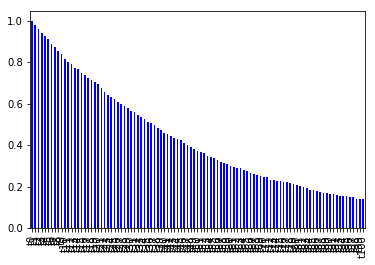

In [3]:
decay_hist_df.mean().plot(kind='bar', color = 'b')

Interesting, we can clearly see a quadratic decay function.  Now let's start using the python package lifelines to do some modelling on this:

In [4]:
import lifelines

First we need to massage the data into the correct format (the observant amongst us will notice that I could've/should've done this with the data from the start, but a bit of pandas practice never hut anyone)

In [5]:
df = pd.DataFrame()
df['event'] = list(decay_hist_df.sum())
df['t'] = list(range(len(df)))
df.head(5)

,event,t
0,1000.0,0
1,980.0,1
2,963.0,2
3,944.0,3
4,925.0,4


Ok, first up Kaplan Meier.  This is you bog standard model, not terribly sophisticated (in fact it's really just a graphical plot, like the best fit line you'd draw in school only with all the dots joined).

In [6]:
from lifelines import KaplanMeierFitter

t = df['t']
event = df['event']

kmf = KaplanMeierFitter()
kmf.fit(t, event_observed=event)


<lifelines.KaplanMeierFitter: fitted with 101 observations, 0 censored>

Ok, now we've fit the model, let's plot it out...

Median:  50.0


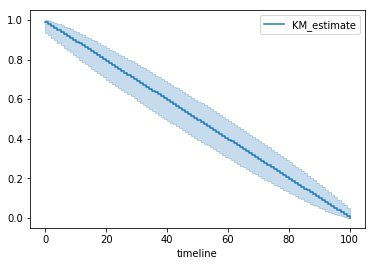

In [7]:
kmf.survival_function_
kmf.confidence_interval_
print('Median: ',kmf.median_)
kmf.plot()

Interesting thus far.  Let's take a look at some more representative data.  The lifelines package comes with some nifty ones:

In [8]:
from lifelines.datasets import load_waltons
df = load_waltons()
t = df['T']
event = df['E']


And we refit with Kaplan Meier

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(t, event_observed=event)

<lifelines.KaplanMeierFitter: fitted with 163 observations, 7 censored>

Median:  56.0


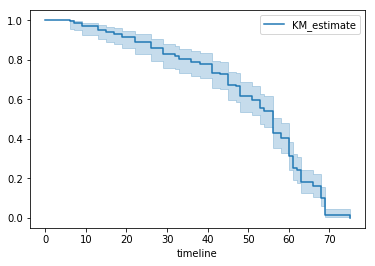

In [10]:
kmf.survival_function_
kmf.confidence_interval_
print('Median: ',kmf.median_)
kmf.plot()

Again we can see the confidence intervals wrapping the KM plot, giving us a sense of the projection quality


In [16]:
from lifelines import CoxPHFitter
#df = pd.get_dummies(df)
#df = df.drop(columns=['group_miR-137'],axis=1) # making for a more compact model, no extra info was/is included in this variable

cph = CoxPHFitter()
cph.fit(df,duration_col='T', event_col='E', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 1.67856, step_size = 0.9500, ll = -646.30919, newton_decrement = 58.57409, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.86383, step_size = 0.9500, ll = -666.22061, newton_decrement = 58.30696, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.02091, step_size = 0.9500, ll = -613.21202, newton_decrement = 0.03035, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00088, step_size = 1.0000, ll = -613.18193, newton_decrement = 0.00005, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -613.18188, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 163 observations, 7 censored>
      duration col = 'T'
         event col = 'E'
number of subjects = 163
  number of events = 156
    log-likelihood = -613.18
  time fit was run = 2019-04-18 13:24:16 UTC

---
               coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  uppe

C:\Users\miketaylor\AppData\Local\Continuum\Anaconda3\envs\py36\lib\site-packages\lifelines\utils\__init__.py:900: ConvergenceWarning: Column group_control have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['E'].astype(bool)
>>> df.loc[events, 'group_control'].var()
>>> df.loc[~events, 'group_control'].var()

Too low variance here means that the column group_control completely determines whether a subject dies or not.
See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


Ok, so let's examine this; the warning is pretty prescient, with the group_control dimension dictating the outcomes.  We can see this backed up by the coefficient estimated by the model, that is -2.05 and a z score which is well within the significant boundary (presumed to be 0.05 given stats' dirty little 1 in 20 secret).  The stats also give us an opportunity to calcualte a BIC score, a neat and super simple (though for now admittedly redundant, given no competing models) way to measure model quality.  The calculation is as follows

$BIC Score = ln(n)k - 2ln(Likelihood)$

where n is the data set size and k is the number of parameters (1 in the case above)


In [21]:
import math
BIC_score = 2* math.log(163)*1 +68.14

print(BIC_score)

78.32750040161352


## Improvements...

So far we've only looked at a single, uber simple, model.  Time to get more into the thick of it.  !st off, let's get ourselves a more complex data set

In [23]:
from lifelines.datasets import load_rossi

rossi_dataset = load_rossi()

In [26]:
rossi_dataset.head(5)

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


That's more like it... Now let's analyse, but time to stick with a Cox Proportional Hazards model

In [27]:
cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.48337, step_size = 0.9500, ll = -675.38063, newton_decrement = 16.76434, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13160, step_size = 0.9500, ll = -659.79004, newton_decrement = 0.99157, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01712, step_size = 0.9500, ll = -658.76197, newton_decrement = 0.01422, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00108, step_size = 1.0000, ll = -658.74771, newton_decrement = 0.00005, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-04-18 13:51:30 UTC

---
      coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  uppe

So, we can see with some certainty that the 'prio', 'fin' and 'age' dimensions have a significant negative relationship with survival, with thre rest being non significant.  Worth noting that fin is only JUST in the significance marker and hence a sliver of p hacking could be in play (if we were reporting these results to ruthless academics)